In [2]:
import mne
import matplotlib.pyplot as plt
import os
import numpy as np

# Read Zenodo data set

In [2]:
import scipy.io
mat=scipy.io.loadmat('../BraiNeoCare/Datasets/zenodo_eeg/annotations_2017.mat')

In [3]:
def signal_array(raw_data):
    ch1=raw_data[0]-raw_data[5]
    ch2=raw_data[5]-raw_data[7]
    ch3=raw_data[0]-raw_data[2]
    ch4=raw_data[2]-raw_data[7]
    ch5=raw_data[1]-raw_data[3]
    ch6=raw_data[3]-raw_data[8]
    ch7=raw_data[1]-raw_data[6]
    ch8=raw_data[6]-raw_data[8]
    ch9=raw_data[5]-raw_data[2]
    ch10=raw_data[2]-raw_data[4]
    ch11=raw_data[4]-raw_data[3]
    ch12=raw_data[3]-raw_data[6]
    return np.array([ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12])

def find_seizure_time(file_no):
    b=mat['annotat_new'][0][file_no-1][0] & mat['annotat_new'][0][file_no-1][1] & mat['annotat_new'][0][file_no-1][2]
    a=np.where(b==1)[0]
    s_time=[]
    e_time=[]
    if len(a)!=0:
        s_time.append(a[0])  
        for r in range(1,a.shape[0]):
            if a[r-1]-a[r]!=-1:
                e_time.append(a[r-1]+1)
                s_time.append(a[r]) 
        e_time.append(a[-1]+1)  
        
    return np.array(s_time),np.array(e_time)



In [4]:
print(mne.__version__)

1.5.1


### Data visualization

Extracting EDF parameters from /home/nima/BraiNeoCare/Datasets/zenodo_eeg/eeg3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_325299/413692793.py:3: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  data = mne.io.read_raw_edf(file)


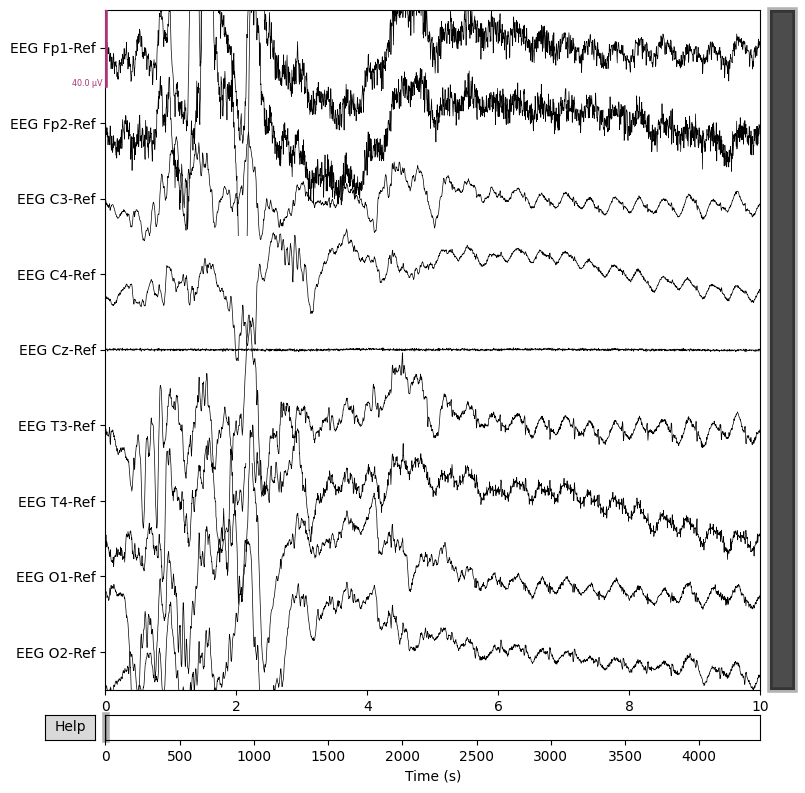

[] []


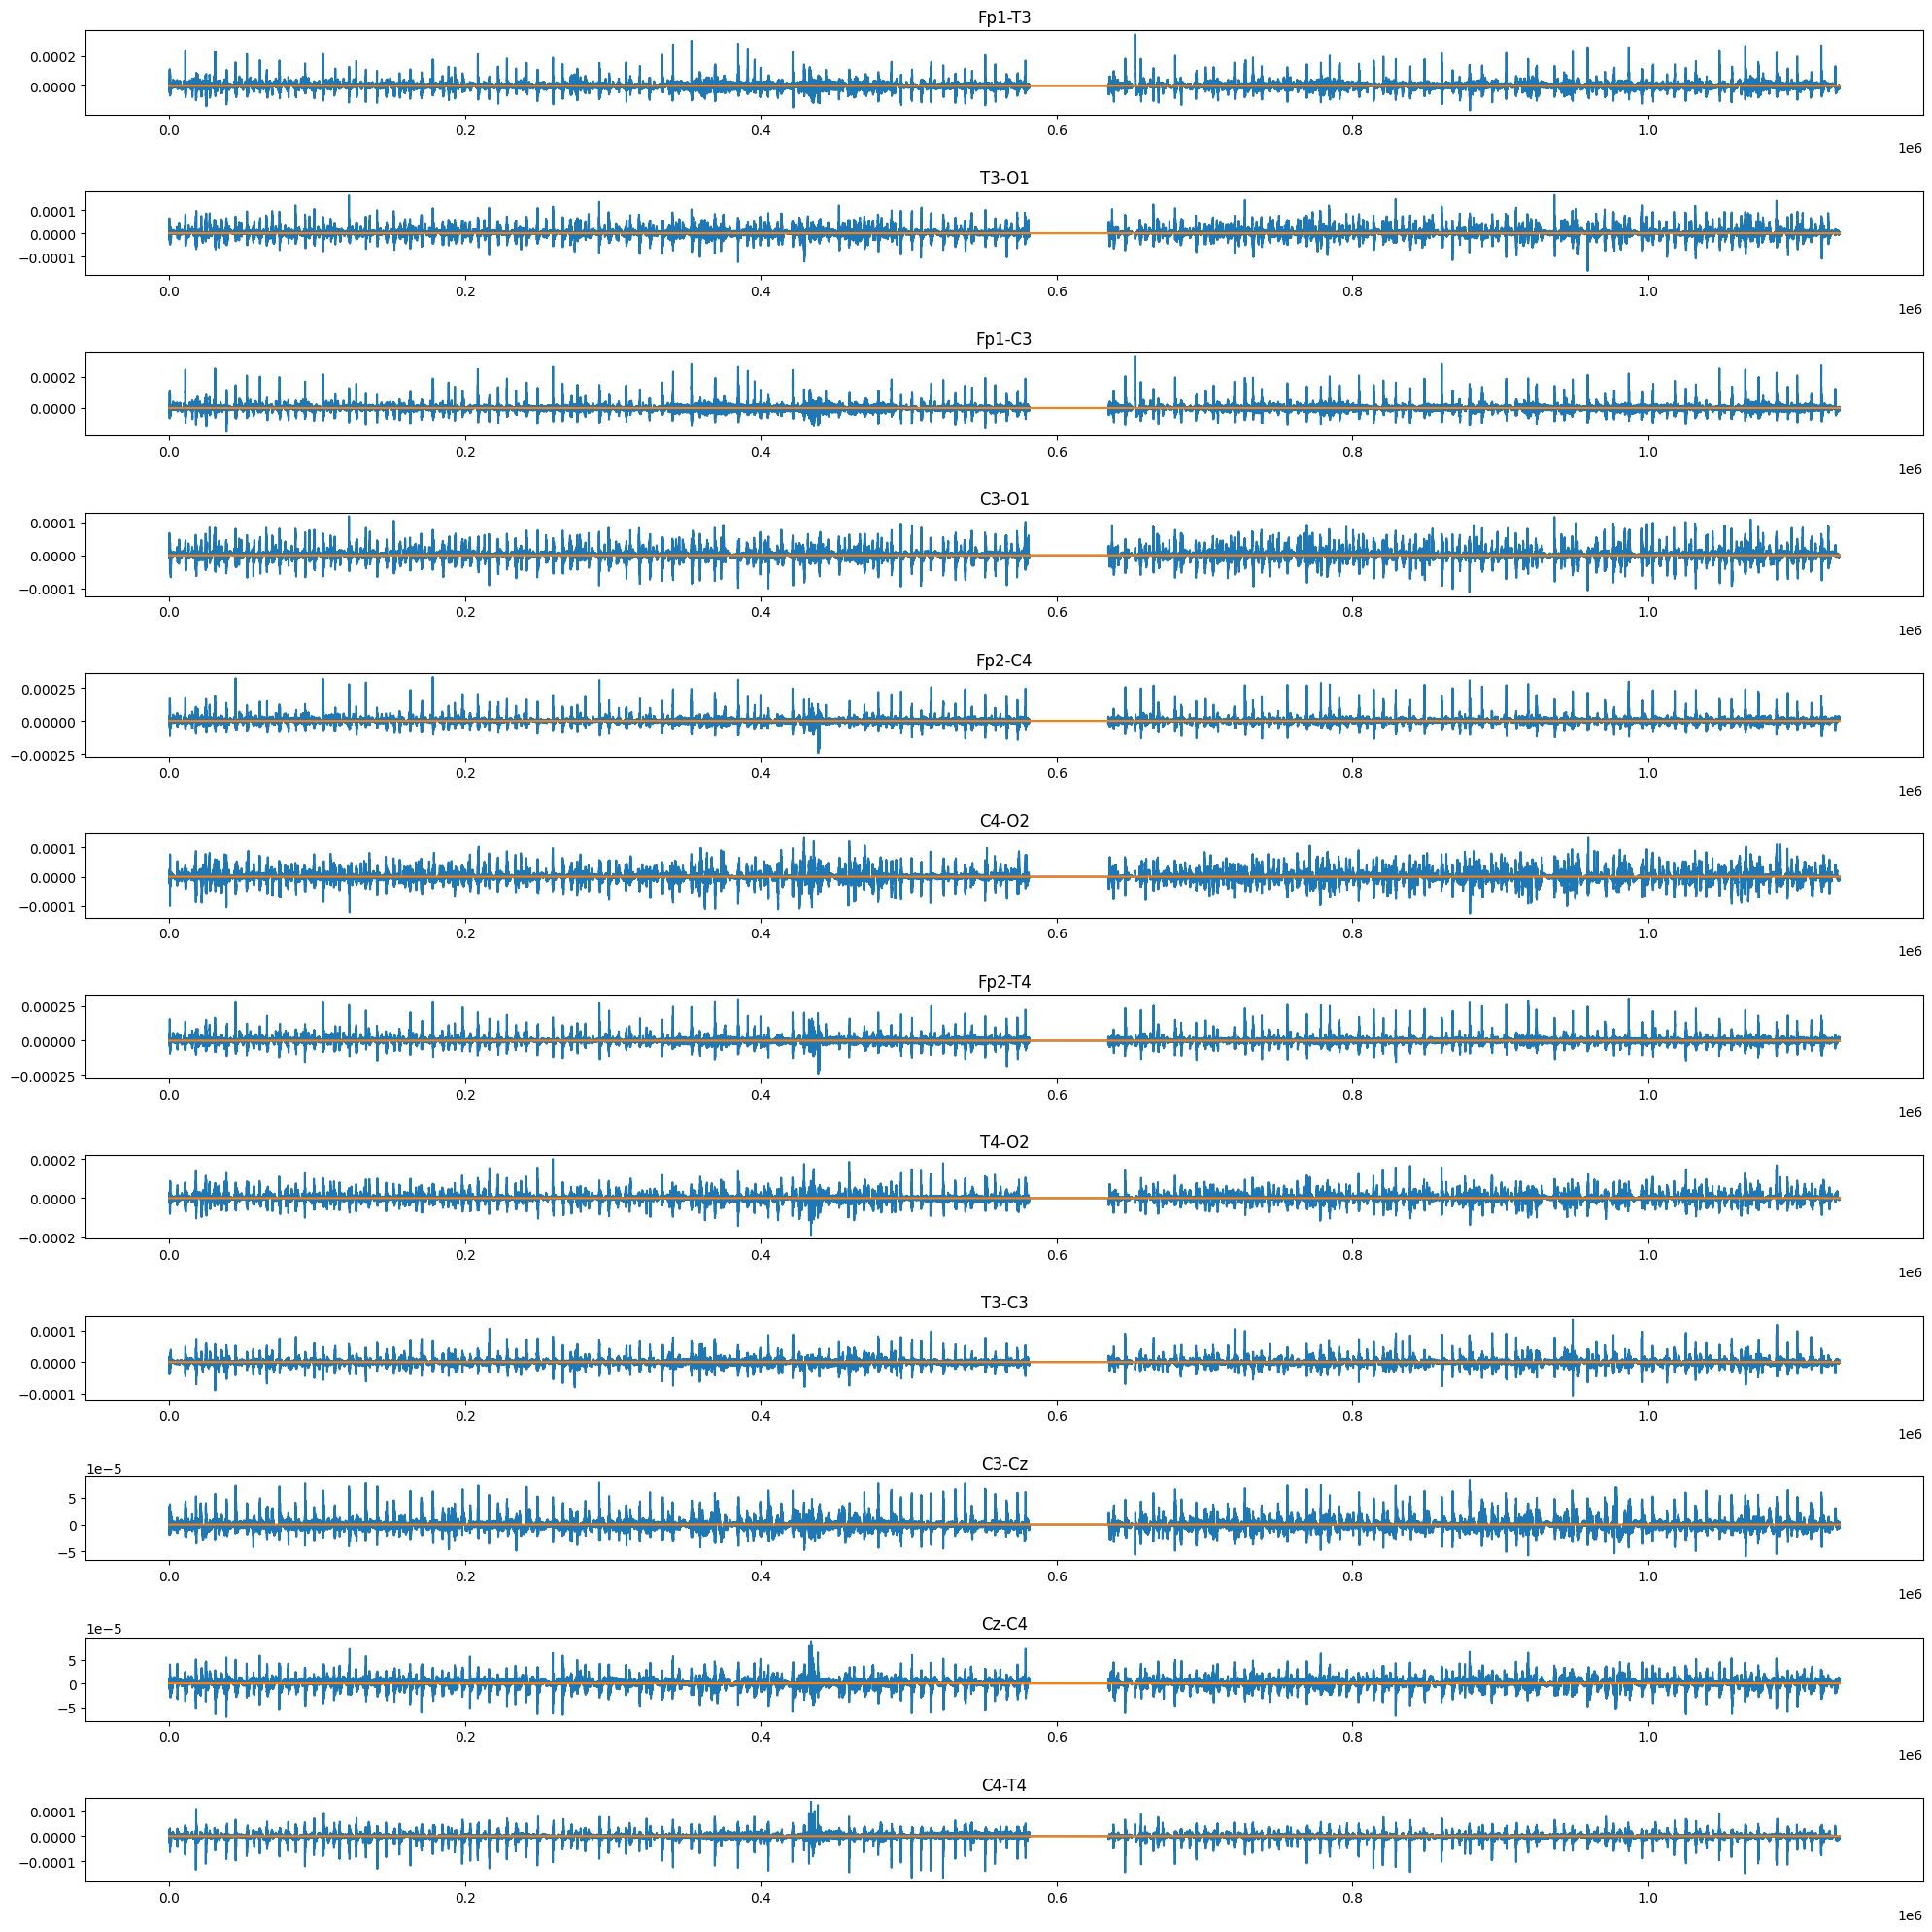

In [5]:
file='../BraiNeoCare/Datasets/zenodo_eeg/eeg3.edf'
try:
    data = mne.io.read_raw_edf(file)
    data=data.pick_channels(['EEG Fp1-Ref', 'EEG Fp2-Ref', 'EEG C3-Ref','EEG C4-Ref', 'EEG Cz-Ref', 'EEG T3-Ref', 'EEG T4-Ref', 'EEG O1-Ref', 'EEG O2-Ref'],ordered=True)
    channel_names=["Fp1-T3","T3-O1","Fp1-C3","C3-O1","Fp2-C4","C4-O2","Fp2-T4","T4-O2","T3-C3","C3-Cz","Cz-C4","C4-T4"]
    data.plot()
    raw_data=data.get_data()
    signal=signal_array(raw_data)

    s_Time,e_Time=find_seizure_time(3) 
    seizures=np.zeros((12,len(signal[0])))
    print(s_Time,e_Time)
    for i in range(12):
        for r in range(len(s_Time)):
            seizures[i,s_Time[r]:e_Time[r]]=signal[i,s_Time[r]:e_Time[r]]

    fig,ax=plt.subplots(12,1,figsize=(20,20))
    for r in range(12):
        ax[r].plot(signal[r])
        ax[r].plot(seizures[r])
        ax[r].set_title(channel_names[r])
    fig.tight_layout()
    plt.show() 
except:
    pass

### Data saving

In [ ]:
folder='../BraiNeoCare/Datasets/zenodo_eeg/'
signals=[]
seizure=[]
files=os.listdir(folder)    

for file in files:
    if file.endswith('.edf'):
        try:
            data = mne.io.read_raw_edf(folder+file)
            data=data.pick_channels(['EEG Fp1-Ref', 'EEG Fp2-Ref',  'EEG C3-Ref', 'EEG C4-Ref', 'EEG Cz-Ref', 'EEG T3-Ref', 'EEG T4-Ref', 'EEG O1-Ref', 'EEG O2-Ref'],ordered=True)
            raw_data=data.get_data()
            signal=signal_array(raw_data)
            
            s_Time,e_Time=find_seizure_time(int(file.split('.')[0][3:])) 
            signal_partition=0
            started=False

            while signal_partition*256<raw_data.shape[1]:

                u_bound=(signal_partition+1)*256
                l_bound=signal_partition*256
                partition=signal[:,l_bound:u_bound]

                if partition.shape[1]==256:
                    signals.append(partition)

                    if (len(s_Time)!=0 ):

                        if np.any((s_Time*256>=l_bound) & (s_Time*256<=u_bound-1)):
                            seizure.append(1)
                            started=True

                        elif np.any((l_bound<(e_Time*256-1)) & ((e_Time*256-1)<=(u_bound-1))):
                            seizure.append(1)
                            started=False

                        elif (started and np.any((e_Time*256-1)>u_bound-1)):
                            seizure.append(1)
                        else:
                            seizure.append(0)
                    else:
                        seizure.append(0)
            
                signal_partition+=1

        except:
            pass

signals=np.array(signals)
seizure=np.array(seizure)
np.save('../BraiNeoCare/Datasets/zenodo_data_common_1s.npy',signals)
np.save('../BraiNeoCare/Datasets/zenodo_labels_common_1s.npy',seizure)

In [3]:
from sklearn.model_selection import train_test_split
x=np.load('../BraiNeoCare/Datasets/zenodo_data_common_4s.npy', mmap_mode='r')
y=np.load('../BraiNeoCare/Datasets/zenodo_labels_common_4s.npy', mmap_mode='r')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
y_train_positive_pos=np.where(y_train==1)
y_test_positive_pos=np.where(y_test==1)

x_train_positive=x_train[y_train_positive_pos]
x_test_positive=x_test[y_test_positive_pos]

y_train_negative_pos=np.where(y_train==0)
y_test_negative_pos=np.where(y_test==0)

x_train_negative=x_train[y_train_negative_pos][0:x_train_positive.shape[0],...]
x_test_negative=x_test[y_test_negative_pos][0:x_test_positive.shape[0],...]

new_x_train=np.concatenate((x_train_positive,x_train_negative),axis=0)
new_y_train=np.concatenate((np.ones((x_train_positive.shape[0],)),np.zeros((x_train_negative.shape[0],))),axis=0)

new_x_test=np.concatenate((x_test_positive,x_test_negative),axis=0)
new_y_test=np.concatenate((np.ones((x_test_positive.shape[0],)),np.zeros((x_test_negative.shape[0],))),axis=0)

np.save('../BraiNeoCare/Datasets/balanced_x_train_common_1s.npy',new_x_train)
np.save('../BraiNeoCare/Datasets/balanced_y_train_common_1s.npy',new_y_train)

np.save('../BraiNeoCare/Datasets/balanced_x_test_common_1s.npy',new_x_test)
np.save('../BraiNeoCare/Datasets/balanced_y_test_common_1s.npy',new_y_test)

In [ ]:
a=np.load('../BraiNeoCare/Datasets/zenodo_labels_common_1s.npy', mmap_mode='r')


# Read chb-mit dataset 

In [ ]:
seizure_files=[]
folder='../ML_codes/chb01/'
for file in os.listdir(folder):
    if file.endswith(".seizures"):
        seizure_files.append(file.split('.')[0])
print(seizure_files)

In [ ]:
def open_annotations(file,name):
    f=open(file,'r')
    lines_list=[]
    for lines in f:
       lines_list.append(lines.strip())
    # print(lines_list)
    index_of_file=lines_list.index("File Name: "+name+".edf")
    start=int(lines_list[index_of_file+4].split(" ")[-2])
    end=int(lines_list[index_of_file+4+1].split(" ")[-2])
    return start,end

In [ ]:
signals=[]
seizure=[]
summary_file='../ML_codes/chb01/chb01-summary.txt'
start, end= 0, 0

for file in os.listdir(folder):
    if file.split('.')[-1]=='edf':       
        data = mne.io.read_raw_edf(folder+file)
        data=data.pick_channels(['FP1-F7','P7-O1','F3-C3','C3-P3','FP2-F8','P8-O2','F4-C4','C4-P4','FZ-CZ','CZ-PZ'])
        raw_data=data.get_data()
        
        if file.split('.')[0] in seizure_files:
            start,end=open_annotations(summary_file,file.split('.')[0])

        signal_partition=0
        started=False

        while signal_partition*1024<raw_data.shape[1]:

            u_bound=(signal_partition+1)*1024
            l_bound=signal_partition*1024
            partition=raw_data[:,l_bound:u_bound]

            if partition.shape[1]==1024:
                signals.append(partition)

                if (start!=0 and end!=0):
                    if ((start*256>=l_bound) and (start*256<=u_bound-1)):
                        seizure.append(1)
                        started=True
                    elif ((l_bound<(end*256-1)) and ((end*256-1)<=(u_bound-1))):
                        seizure.append(1)
                        started=False
                    elif (started and ((end*256-1)>u_bound-1)):
                        seizure.append(1)
                    else:
                        seizure.append(0)
                else:
                    seizure.append(0)
        
            signal_partition+=1

signals=np.array(signals)
seizure=np.array(seizure)
np.save('chb001_data',signals)
np.save('chb001_labels',seizure)